In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from rubin_sim.selfcal import generate_catalog, OffsetSys, OffsetSNR
import sqlite3
from rubin_sim.data import get_baseline

from rubin_sim.utils import healbin
import healpy as hp

In [2]:
baseline_survey = get_baseline()
baseline_survey

con = sqlite3.connect(baseline_survey)
visits_df = pd.read_sql("select observationId, fieldra as ra,fielddec as dec,fiveSigmaDepth,rotSkyPos from observations where filter='g' and fieldra < 10 and fielddec > -20 and fielddec < -10 and night < 730;", con)
con.close()

# what is the right way to do this?
names =['observationId', 'ra', 'dec', 'fiveSigmaDepth', 'rotSkyPos']
types = [int, float, float, float, float]
visits = np.empty(visits_df.shape[0], dtype=list(zip(names, types)))

for key in names:
    visits[key] = visits_df[key].values


In [3]:
visits.shape

(139,)

In [4]:
filter_name = "g"

con = sqlite3.connect("msrgb_1e6.sqlite")
stars_df = pd.read_sql("select id,ra,decl,%smag from stars;" % filter_name, con)
con.close()

# what is the right way to do this? There's gotta be a better way!
names =['id', 'ra', 'decl', '%smag' % filter_name]
types = [int, float, float, float]
stars = np.empty(stars_df.shape[0], dtype=list(zip(names, types)))
for key in names:
    stars[key] = stars_df[key].values



In [5]:
stars

array([(      2,   0.368681, -89.0753  , 17.465 ),
       (      3,   2.44785 , -89.4834  , 18.1409),
       (      4,   5.25501 , -89.8479  , 17.5175), ...,
       (1337078, 337.148   ,  -0.788291, 17.0037),
       (1337079, 345.546   ,  -0.758393, 18.2861),
       (1337080, 353.166   ,  -0.94849 , 17.7995)],
      dtype=[('id', '<i8'), ('ra', '<f8'), ('decl', '<f8'), ('gmag', '<f8')])

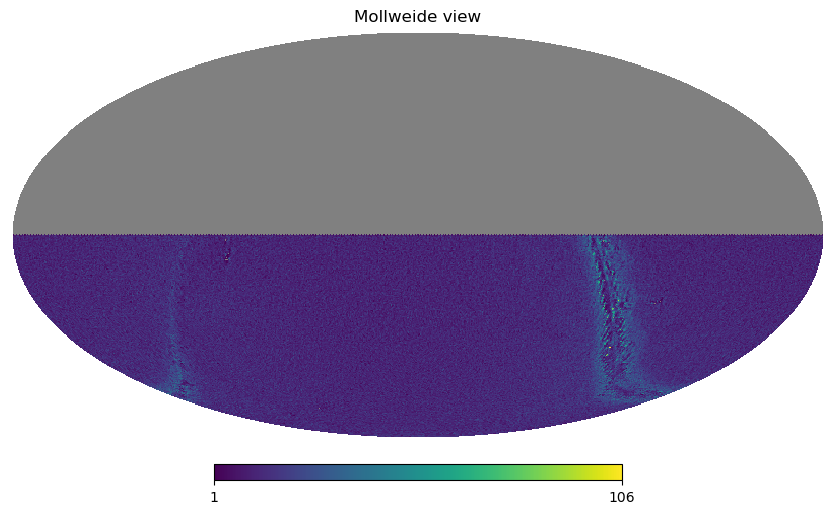

In [6]:
star_density = healbin(stars["ra"], stars["decl"], stars["ra"]*0+1, 128, reduce_func=np.sum)
hp.mollview(star_density)

In [7]:
# Let's throw a 1% systematic error in there, so we have something to work with
offsets = [OffsetSys(error_sys=0.01), OffsetSNR(lsst_filter=filter_name)]


In [8]:
observed_stars = generate_catalog(visits, stars, offsets=offsets, lsst_filter=filter_name)

progress = 99.28%

In [9]:
observed_stars


array([(798320,  191238, 17.27775549, 0.00500734, 17.2729, 5.53746, -11.7762),
       (798314,  191238, 17.36537406, 0.00500863, 17.3669, 5.61585, -11.9377),
       (798377,  191234, 18.15751323, 0.005037  , 18.1513, 5.53013, -11.7233),
       ...,
       (764383, 6430220, 17.65633   , 0.00500612, 17.6701, 9.38199, -13.9339),
       (764337, 6430213, 17.56483627, 0.00500517, 17.5645, 9.18779, -13.4496),
       (764339, 6430213, 18.11031423, 0.00501412, 18.1074, 9.32786, -13.4679)],
      dtype=[('id', '<i8'), ('patchID', '<i8'), ('observed_mag', '<f8'), ('mag_uncert', '<f8'), ('gmag', '<f8'), ('ra', '<f8'), ('decl', '<f8')])

In [10]:
observed_stars['observed_mag']

array([17.27775549, 17.36537406, 18.15751323, ..., 17.65633   ,
       17.56483627, 18.11031423])

In [11]:
stars[np.where(stars['id'] == 234065)]

array([(234065, 251.753, -50.4246, 18.7788)],
      dtype=[('id', '<i8'), ('ra', '<f8'), ('decl', '<f8'), ('gmag', '<f8')])

In [12]:
observed_stars.size

79370

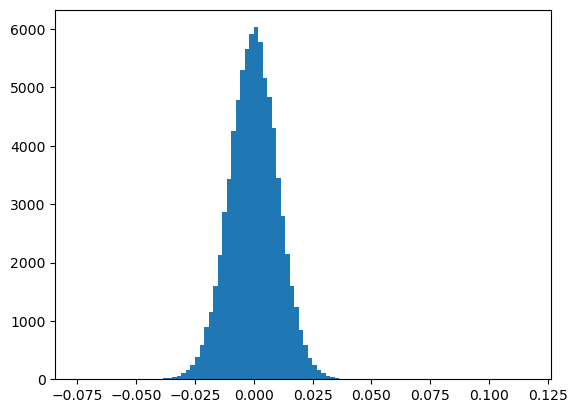

In [13]:
_temp = plt.hist(observed_stars['%smag' % filter_name] - observed_stars['observed_mag'], bins=100)

In [14]:
resid = healbin(observed_stars["ra"], observed_stars["decl"], observed_stars['%smag' % filter_name] - observed_stars['observed_mag'], 128)

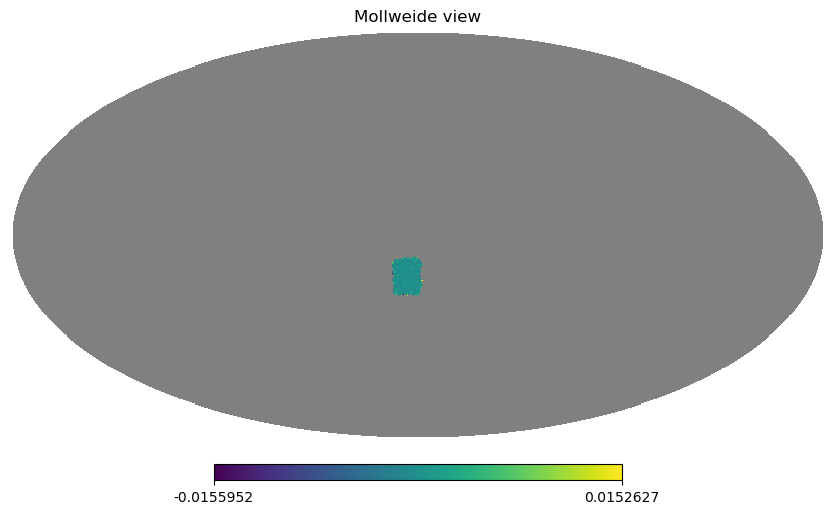

In [15]:
hp.mollview(resid)